In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from estimators import *
from utils import *

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

,S,d,n,True mean Y0,Impute mean Y0,Drop mean Y0,Oracle-IPCW mean Y0,True mean Y1,Impute mean Y1,Drop mean Y1,Oracle-IPCW mean Y1,True ATE,Impute ATE,Drop ATE,Oracle-IPCW ATE
0,0,10,1000,1.830252,1.788795,1.785359,1.780564,4.767515,4.811462,4.775539,5.002974,2.937263,3.022667,2.990180,3.222410
1,1,10,3000,1.805182,1.943346,1.931201,1.786166,4.021637,3.029292,3.022973,3.328790,2.216455,1.085946,1.091771,1.542624


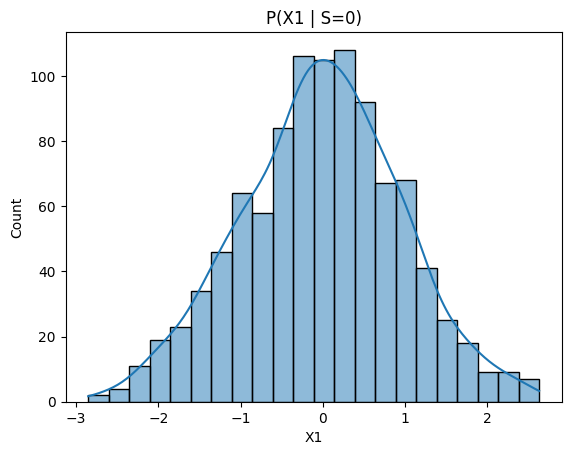

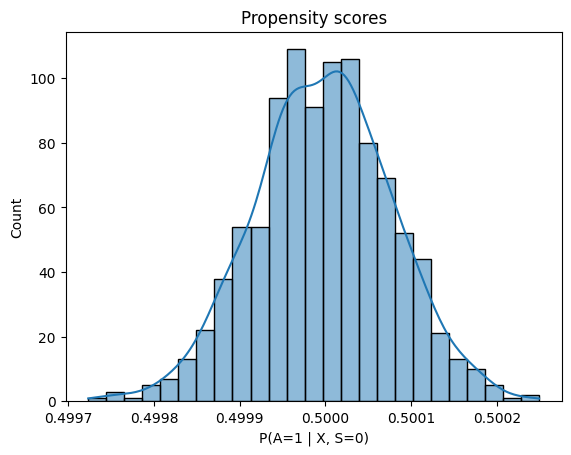

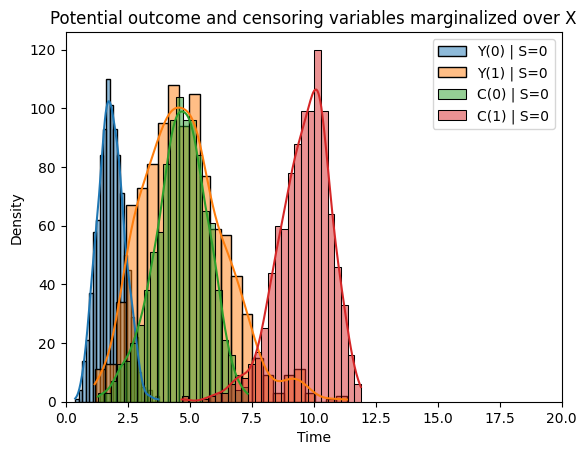

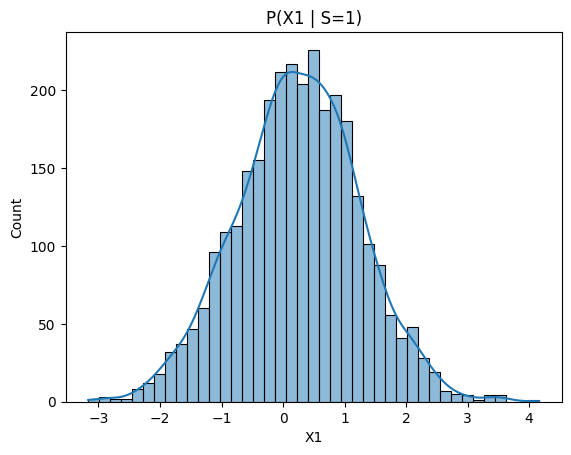

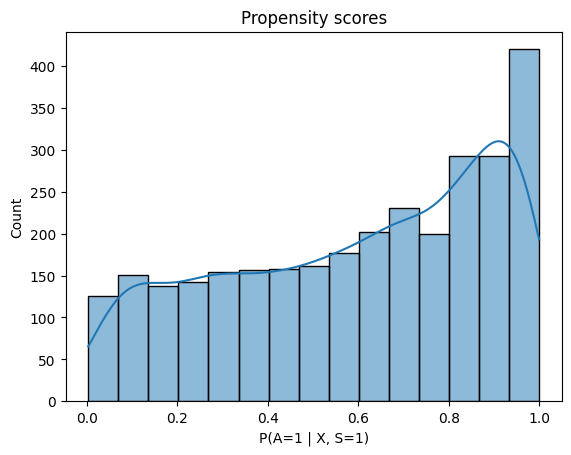

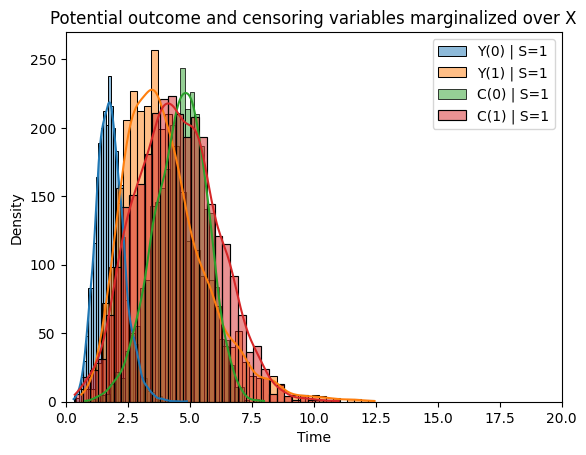

In [3]:
m = 3
CD = 10
UC = 0

jD = read_json('complete-IC/samePO.json', CD, UC)

RCTData = SyntheticDataModule(jD['save_df'], CD, jD['rct_size'], 0, jD['RCT']['px_dist'], jD['RCT']['px_args'], jD['RCT']['prop_fn'], jD['RCT']['prop_args'], jD['RCT']['tte_params'])
OSData = SyntheticDataModule(jD['save_df'], CD, jD['rct_size'] * m, 1, jD['OS']['px_dist'], jD['OS']['px_args'], jD['OS']['prop_fn'], jD['OS']['prop_args'], jD['OS']['tte_params'])

df_rct_oracle, df_rct = RCTData.get_df()
df_os_oracle, df_os = OSData.get_df()

df_combined = pd.concat([df_rct, df_os], axis=0, ignore_index=True)  # merge the dataframes into one
df_comb_drop = df_combined.query('Delta == 1').reset_index(drop=True).copy()  # drop the censored observations

# Estimate the nuisance parameters for the combined dataframe

df_combined['P(S=1|X)'] = prop_score_est(df_combined.copy(), 'S', jD['cov_list'], 'logistic')

df_combined.loc[df_combined.S==0, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==0').copy(), 'A', jD['cov_list'], 'logistic')
df_combined.loc[df_combined.S==1, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==1').copy(), 'A', jD['cov_list'], 'logistic')

cbse, ybse = est_surv(df_combined, jD['cov_list'], tte_model='coxph')
calc_barG(df_combined, jD['cov_list'], cbse)

ipcw_est(df_combined, S=0)
ipcw_est(df_combined, S=1)
ipw_est(df_combined, S=0, baseline='impute')  # calling on the dataframe where censored observations are NOT dropped
ipw_est(df_combined, S=1, baseline='impute')  # calling on the dataframe where censored observations are NOT dropped

# Estimate the nuisance parameters for the combined dataframe with censored observations dropped

df_comb_drop['P(S=1|X)'] = prop_score_est(df_comb_drop.copy(), 'S', jD['cov_list'], 'logistic')

df_comb_drop.loc[df_comb_drop.S==0, 'P(A=1|X,S)'] = prop_score_est(df_comb_drop.query('S==0').copy(), 'A', jD['cov_list'], 'logistic')
df_comb_drop.loc[df_comb_drop.S==1, 'P(A=1|X,S)'] = prop_score_est(df_comb_drop.query('S==1').copy(), 'A', jD['cov_list'], 'logistic')

ipw_est(df_comb_drop, S=0, baseline='drop')  # calling on the dataframe where censored observations are dropped
ipw_est(df_comb_drop, S=1, baseline='drop')  # calling on the dataframe where censored observations are dropped

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

In [ ]:
df_combined['P(S=1|X)'].max()

In [ ]:
df_new = df_combined
df_new_drop = df_comb_drop

In [ ]:
print('IPCW-S0-Y0: {:.2f}'.format(df_new['S0_ipcw_est_Y0'].mean()))
print('IPCW-S0-Y1: {:.2f}'.format(df_new['S0_ipcw_est_Y1'].mean()))
print('IPCW-S0-ATE: {:.2f}\n'.format(df_new['S0_ipcw_est_CATE'].mean()))

print('IPCW-S1-Y0: {:.2f}'.format(df_new['S1_ipcw_est_Y0'].mean()))
print('IPCW-S1-Y1: {:.2f}'.format(df_new['S1_ipcw_est_Y1'].mean()))
print('IPCW-S1-ATE: {:.2f}\n'.format(df_new['S1_ipcw_est_CATE'].mean()))

print('IPW-Impute-S0-Y0: {:.2f}'.format(df_new['S0_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S0-Y1: {:.2f}'.format(df_new['S0_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S0-ATE: {:.2f}\n'.format(df_new['S0_impute_ipw_est_CATE'].mean()))

print('IPW-Impute-S1-Y0: {:.2f}'.format(df_new['S1_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S1-Y1: {:.2f}'.format(df_new['S1_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S1-ATE: {:.2f}\n'.format(df_new['S1_impute_ipw_est_CATE'].mean()))

print('IPW-Drop-S0-Y0: {:.2f}'.format(df_new_drop['S0_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S0-Y1: {:.2f}'.format(df_new_drop['S0_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S0-ATE: {:.2f}\n'.format(df_new_drop['S0_drop_ipw_est_CATE'].mean()))

print('IPW-Drop-S1-Y0: {:.2f}'.format(df_new_drop['S1_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S1-Y1: {:.2f}'.format(df_new_drop['S1_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S1-ATE: {:.2f}'.format(df_new_drop['S1_drop_ipw_est_CATE'].mean()))

summary_df

In [ ]:
p_thr = 0.05

df_new = df_combined[(p_thr < df_combined['P(S=1|X)']) & (df_combined['P(S=1|X)'] < 1 - p_thr) &\
            (p_thr < df_combined['P(A=1|X,S)']) & (df_combined['P(A=1|X,S)'] < 1 - p_thr)].copy().reset_index(drop=True)

df_new_drop = df_comb_drop[(p_thr < df_comb_drop['P(S=1|X)']) & (df_comb_drop['P(S=1|X)'] < 1 - p_thr) &\
            (p_thr < df_comb_drop['P(A=1|X,S)']) & (df_comb_drop['P(A=1|X,S)'] < 1 - p_thr)].copy().reset_index(drop=True)

In [ ]:
len(df_new)

In [ ]:
df_combined.sort_values(by='P(S=1|X)')

In [ ]:
df_new.sort_values(by='P(S=1|X)')['P(S=1|X)']

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [ ]:
t = np.linspace(0,10,101)
cov_vals = np.zeros(11)
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')

plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha=0.8, ls ='--')
plt.plot(ybse['t_S0_A0'], ybse['St_S0_A0'])
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [ ]:
t = np.linspace(0,10,101)
cov_vals = [0, 0, 0, 0]
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')

plt.figure()
plt.plot(t, tbs_C1, label='C1', alpha=0.8, ls ='--')
plt.plot(cbse['t_S0_C1'], cbse['St_S0_C1'])
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [ ]:
t = np.linspace(0,10,101)
cov_vals = [0, 0, 0, 0]
tbs_C0 = OSData.get_oracle_surv_curve(t, cov_vals, 'C0')

plt.figure()
plt.plot(t, tbs_C0, label='C0', alpha=0.8, ls ='--')
plt.plot(cbse['t_S1_C0'], cbse['St_S1_C0'])
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [ ]:
t = np.linspace(0,10,101)
cov_vals = [0, 0, 0, 0]
tbs_C1 = OSData.get_oracle_surv_curve(t, cov_vals, 'C1')

plt.figure()
plt.plot(t, tbs_C1, label='C1', alpha=0.8, ls ='--')
plt.plot(cbse['t_S1_C1'], cbse['St_S1_C1'])
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [4]:
s, a = 0, 0
ty, sty = ybse[f't_S{s}_A{a}'], ybse[f'St_S{s}_A{a}']
tc, stc = cbse[f't_S{s}_A{a}'], cbse[f'St_S{s}_A{a}']

Result of integration: 17.413434408954362


/tmp/ipykernel_2268298/2202068930.py:9: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(func, 0, t_arr.max() + 10, limit=100)


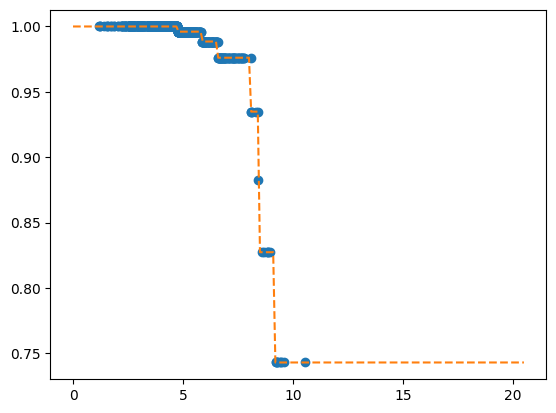

In [48]:
s, a = 0, 1
ty, sty = ybse[f't_S{s}_A{a}'], ybse[f'St_S{s}_A{a}']
tc, stc = cbse[f't_S{s}_A{a}'], cbse[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

func = interp1d(t_arr, st_arr, kind='nearest-up', fill_value='extrapolate')
result, _ = quad(func, 0, t_arr.max() + 10, limit=100)

print("Result of integration:", result)

xnew = np.arange(0, t_arr.max() + 10, 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [40]:
t_arr.max()

10.538002116934331

In [54]:
np.unique(stc)

array([0.74294397, 0.8273007 , 0.88224071, 0.93485612, 0.97609998,
       0.98850219, 0.99604465, 1.        ])

In [51]:
len(tc)

503

In [57]:
stcder = [stc[i+1] - stc[i] for i in range(len(stc) - 1)]

In [59]:
np.unique(stcder)

array([-0.08435673, -0.05494001, -0.0526154 , -0.04124386, -0.01240221,
       -0.00754246, -0.00395535,  0.        ])

In [52]:
x = np.array([1, 2, 4, 7, 11])

# Calculate the derivative using numpy.gradient()
dx = np.gradient(x)

print(dx)

[1.  1.5 2.5 3.5 4. ]


In [60]:
len(np.gradient(stc))

503

In [61]:
len(stc)

503

In [62]:
np.gradient(1 - stc)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [67]:
target_val = 5
t_arr[np.argmin(np.abs(target_val - t_arr))]

5.004191551972425

In [70]:
np.argmax(t_arr[np.where(t_arr < target_val)[0]])

289

In [76]:
np.where(t_arr < target_val)[0][-1]

289